# <span style="color:blue">Esercitazione 1</span>

### Esercizio 07.1

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl

nstep=int(np.genfromtxt('results/output.solid.epot.ist',max_rows=1))
nstp=(3000,3000)   #we are interested for burn-in in nstp[0] first and nstp[1] last steps
head=(1,nstep-nstp[1]); max_r=(nstp[0],nstep)
lab_state=['solid','liquid','gas']; title_burn=('First','Last')
title=('Potential energy','Pressure')

In [2]:
def graph_burn(meas):   #meas is "epot" or "pres"
    label=lab_state.copy()
    
    pl.figure(figsize=(15,5))
    for i in range(2):
        obs_s=np.genfromtxt('results/output.solid.'+meas+'.ist',skip_header=head[i],max_rows=max_r[i],names='x,u')
        obs_l=np.genfromtxt('results/output.liquid.'+meas+'.ist',skip_header=head[i],max_rows=max_r[i],names='x,u')
        obs_g=np.genfromtxt('results/output.gas.'+meas+'.ist',skip_header=head[i],max_rows=max_r[i],names='x,u')
        obs=(obs_s,obs_l,obs_g)
        p_rescale=(20.,8.,1.); y_lab=('$U$','$P$')
        if meas=="pres":
            for k in range(3): obs[k]['u']/=p_rescale[k]; label[k]=lab_state[k]+' (/'+str(int(p_rescale[k]))+')'

        pl.subplot(1,2,i+1)
        for j in range(3): pl.plot(obs[j]['x'],obs[j]['u'],label=label[j])
        if meas=="epot": pl.ylim(-9,0)
        elif meas=="pres": pl.ylim(-0.7,0.5)
        pl.legend(loc='best')
        pl.xlabel('$N_{stp}$')
        if i==0: pl.ylabel(y_lab[i],labelpad=15)
        pl.title(title_burn[i]+' '+str(nstp[i])+' points')
        pl.grid(True)
        
    if meas=="epot": pl.suptitle(title[0])
    elif meas=="pres": pl.suptitle(title[1])
    pl.show()

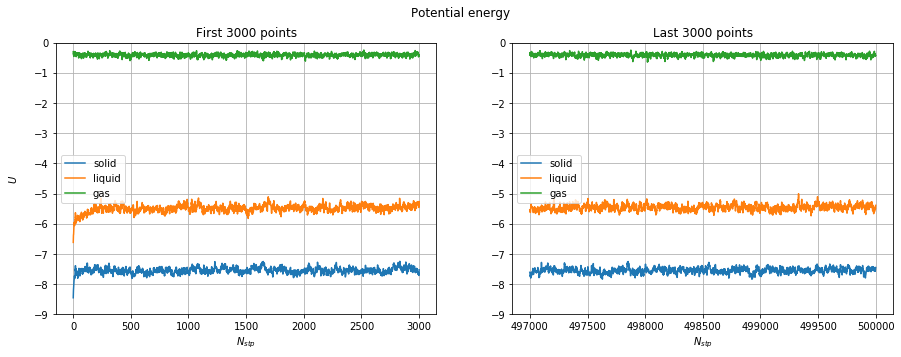

In [3]:
graph_burn("epot")

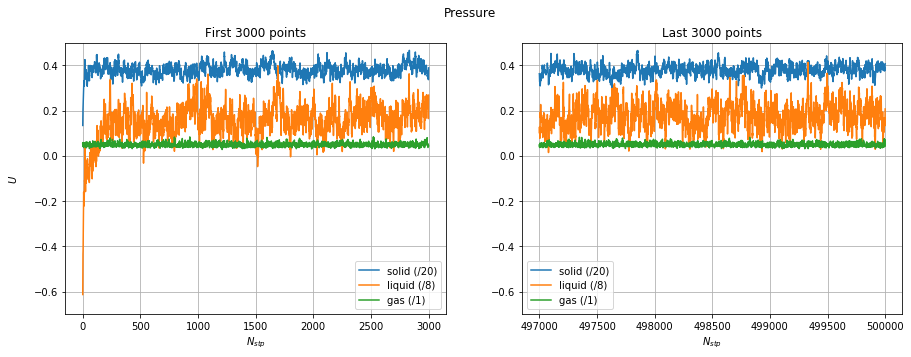

In [4]:
graph_burn("pres")

In [5]:
long=500           #t in graph, but I use tmax=20*long to reduce near tmax fluctuations (not all data for efficiency)
t,tmax=np.arange(long),20*long

def autocorr(state,meas):   #state can be "solid","liquid","gas"; meas can be "epot", "pres"
    data=np.genfromtxt('results/output.'+state+'.'+meas+'.ist',skip_header=1,max_rows=tmax,usecols=(1))
    summ=[np.zeros(long) for i in range(3)]
    summ[0]=[sum(data[0:tmax-tt]*data[tt:tmax]) for tt in t]
    summ[1]=[sum(data[0:tmax-tt]) for tt in t]
    summ[2]=[sum(data[tt:tmax]) for tt in t]
    for i in range(3): summ[i]/=tmax-t
    a=1./tmax*sum(data**2)-(1./tmax*sum(data))**2
    return (summ[0]-summ[1]*summ[2])/a

In [6]:
print("computing energy autocorrelation...")
Ac_ene=(autocorr('solid','epot'),autocorr('liquid','epot'),autocorr('gas','epot'))
print("computing pressure autocorrelation...")
Ac_pres=(autocorr('solid','pres'),autocorr('liquid','pres'),autocorr('gas','pres'))
Ac=(Ac_ene,Ac_pres)

computing energy autocorrelation...
computing pressure autocorrelation...


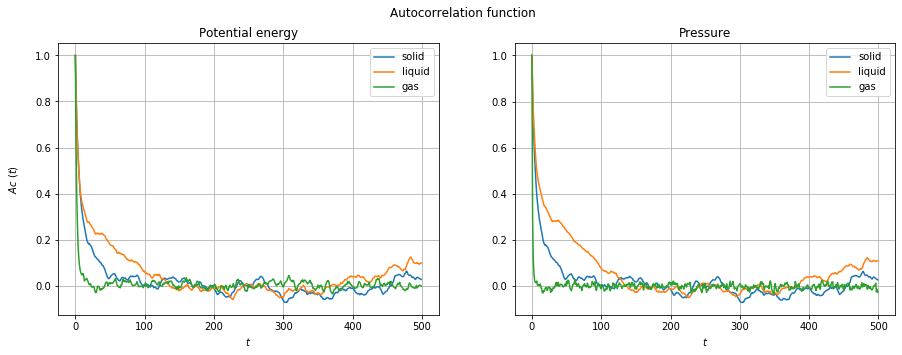

In [7]:
pl.figure(figsize=(15,5))
for i in range(2):
    pl.subplot(1,2,i+1)
    for j in range(3): pl.plot(t,Ac[i][j],label=lab_state[j])
    pl.legend(loc='best')
    pl.xlabel('$t$')
    if i==0: pl.ylabel('$Ac\ (t)$',labelpad=15)
    pl.title(title[i])
    pl.grid(True)
pl.suptitle('Autocorrelation function')
pl.show()

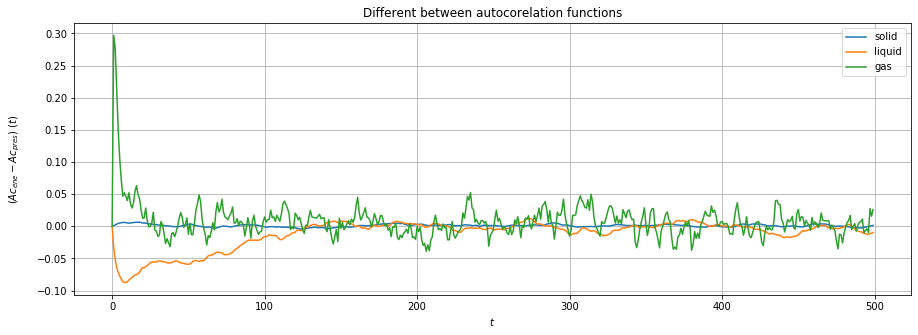

In [8]:
pl.figure(figsize=(15,5))
for j in range(3): pl.plot(t,Ac[0][j]-Ac[1][j],label=lab_state[j])
pl.legend(loc='best')
pl.xlabel('$t$')
pl.ylabel('$(Ac_{ene}-Ac_{pres})\ (t)$',labelpad=15)
pl.title('Different between autocorelation functions')
pl.grid(True)
pl.show()

In [9]:
stepL,maxL=10,5000
tmax=int(5e5)
L=np.arange(0)
for i in range(stepL,maxL+stepL,stepL):
    if tmax%i==0: L=np.append(L,i)
nnL=len(L) 

def Nblock_err(state,meas):
    data=np.genfromtxt('results/output.'+state+'.'+meas+'.ist',skip_header=1,usecols=(1))
    aveBlk=[sum(data[x:x+l])/l   for l in L   for x in range(0,tmax,l)]
    ave2Blk=[x**2 for x in aveBlk]

    errEne=np.zeros(nnL)
    done=0
    for i in range(nnL):
        nblk=int(tmax/L[i])
        summ=sum(aveBlk[done:done+nblk])/nblk
        sum2=sum(ave2Blk[done:done+nblk])/nblk
        errEne[i]=np.sqrt((nblk+1.)*(sum2-summ*summ))/nblk
        done+=nblk
    return errEne

In [10]:
scale_g=(4,200)
print("computing energy uncertainties...")
err_ene=(Nblock_err('solid','epot'),Nblock_err('liquid','epot'),scale_g[0]*Nblock_err('gas','epot'))
print("computing pressure uncertainties...")
err_pres=(Nblock_err('solid','pres'),Nblock_err('liquid','pres'),scale_g[1]*Nblock_err('gas','pres'))
err=(err_ene,err_pres)

computing energy uncertainties...
computing pressure uncertainties...


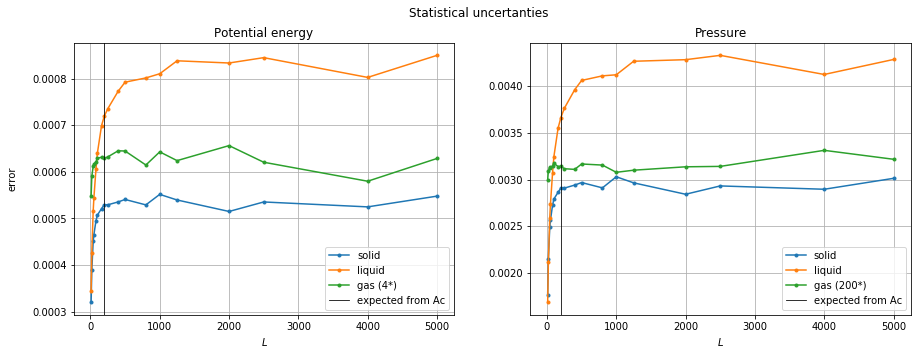

In [11]:
label=lab_state.copy()

pl.figure(figsize=(15,5))
for i in range(2):
    pl.subplot(1,2,i+1)
    label[2]=lab_state[2]+' ('+str(scale_g[i])+'*)'
    for j in range(3): pl.plot(L,err[i][j],marker='.',label=label[j])
    pl.axvline(x=200,color='k',linewidth=0.8,label='expected from Ac')
    pl.legend(loc='best')
    pl.xlabel('$L$')
    if i==0: pl.ylabel('error',labelpad=15)
    pl.title(title[i])
    pl.grid(True)
pl.suptitle('Statistical uncertanties')
pl.show()

### Esercizio 07.2

In [12]:
sig=0.34                            #sigma [nm]
kB,eps_kB=1.98064852e-23,120.       #Boltzmann constant [J/K], eps/kB [K]
eps=eps_kB*kB;                      #eps [J]

In [13]:
EpotS=np.genfromtxt('results/output.solid.epot.0',usecols=(0,2,3),names='nblk,res,err')
EpotL=np.genfromtxt('results/output.liquid.epot.0',usecols=(0,2,3),names='nblk,res,err')
EpotG=np.genfromtxt('results/output.gas.epot.0',usecols=(0,2,3),names='nblk,res,err')
PS=np.genfromtxt('results/output.solid.pres.0',usecols=(0,2,3),names='nblk,res,err')
PL=np.genfromtxt('results/output.liquid.pres.0',usecols=(0,2,3),names='nblk,res,err')
PG=np.genfromtxt('results/output.gas.pres.0',usecols=(0,2,3),names='nblk,res,err')
obs=(EpotS,PS,EpotL,PL,EpotG,PG)

def obs_graph(ifAr):    #if ifAr=True we are studying Argon
    obs_label=(', Epot',', pressure'); y_lab=['$<E_{pot}>$','$<P>$']
    if ifAr:
        for i in range(6):
            obs[i]['res']*=eps; obs[i]['err']*=eps
            if i%2==1: obs[i]['res']*=1e18/(sig**3); obs[i]['err']*=1e18/(sig**3)
        y_lab[0]+='$\ [J]$'; y_lab[1]+='$\ [N/m^2]$'

    pl.figure(figsize=(15,10))
    for i in range(6):
        pl.subplot(3,2,i+1)
        pl.errorbar(obs[i]['nblk'],obs[i]['res'],yerr=obs[i]['err'],marker='.',label=lab_state[i//2]+obs_label[i%2])
        pl.legend(loc='best')
        if i>3: pl.xlabel('$N_{blk}$')
        pl.ylabel(y_lab[i%2],labelpad=15)
        pl.grid(True)
    pl.subplots_adjust(wspace=0.3)
    pl.show()

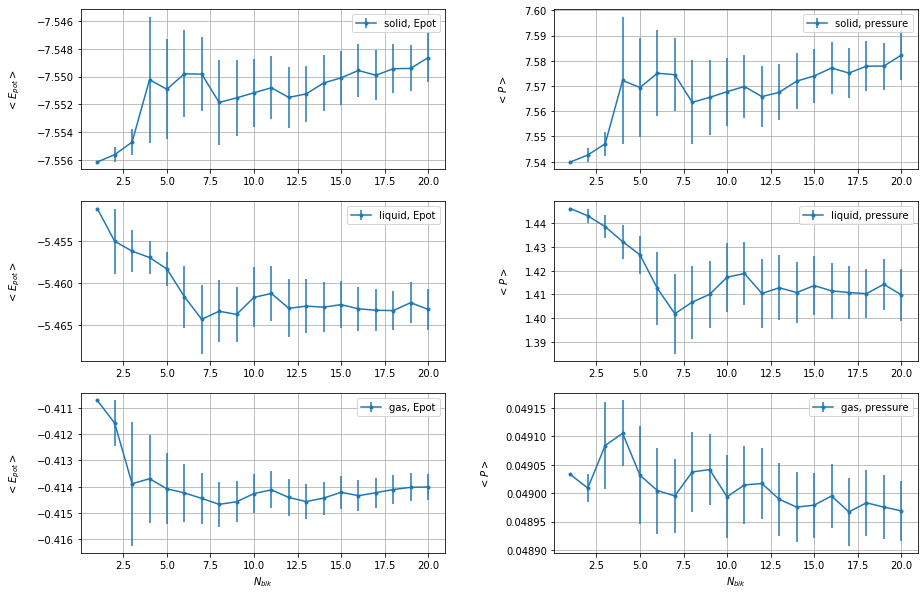

In [14]:
obs_graph(False)

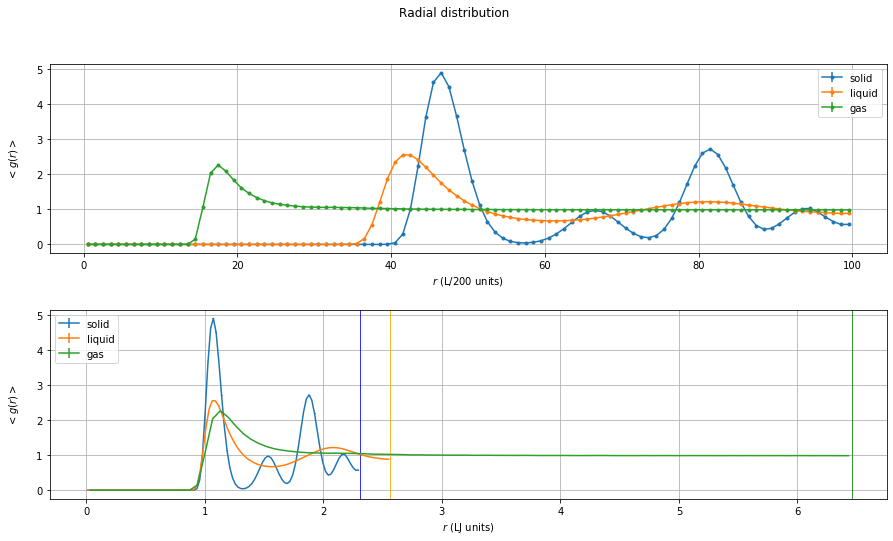

In [15]:
L_s,binS=np.genfromtxt('results/output.solid.gave.0',max_rows=1)             # Number of throws in each block, bin size
L_l,binL=np.genfromtxt('results/output.liquid.gave.0',max_rows=1) 
L_g,binG=np.genfromtxt('results/output.gas.gave.0',max_rows=1) 
gS=np.genfromtxt('results/output.solid.gave.0',skip_header=1,names='nbin,res,err')
gL=np.genfromtxt('results/output.liquid.gave.0',skip_header=1,names='nbin,res,err')
gG=np.genfromtxt('results/output.gas.gave.0',skip_header=1,names='nbin,res,err')
        
L=(L_s,L_l,L_g); bin_width=(binS,binL,binG)
gofr=[gS,gL,gG]; colors=('blue','orange','green')
for i in range(3): gofr[i]['nbin']+=1./2.      

pl.figure(figsize=(15,8))
for k in range (2):
    pl.subplot(2,1,k+1)
    for i in range(3):
        if k==0: pl.errorbar(gofr[i]['nbin'],gofr[i]['res'],yerr=gofr[i]['err'],marker='.',label=lab_state[i])
        else:
            gofr[i]['nbin']*=bin_width[i]
            pl.errorbar(gofr[i]['nbin'],gofr[i]['res'],yerr=gofr[i]['err'],label=lab_state[i])
            pl.axvline(x=100*bin_width[i],color=colors[i],linewidth=0.8)
    pl.legend(loc='best')
    if k==0: pl.xlabel('$r$ (L/200 units)')
    else: pl.xlabel('$r$ (LJ units)')
    pl.ylabel('$<g(r)>$',labelpad=15)
    pl.grid(True)
pl.subplots_adjust(hspace=0.3)
pl.suptitle('Radial distribution')
pl.show()

gAr=gofr.copy();

### Esercizio 07.3

### Esercizio 07.4

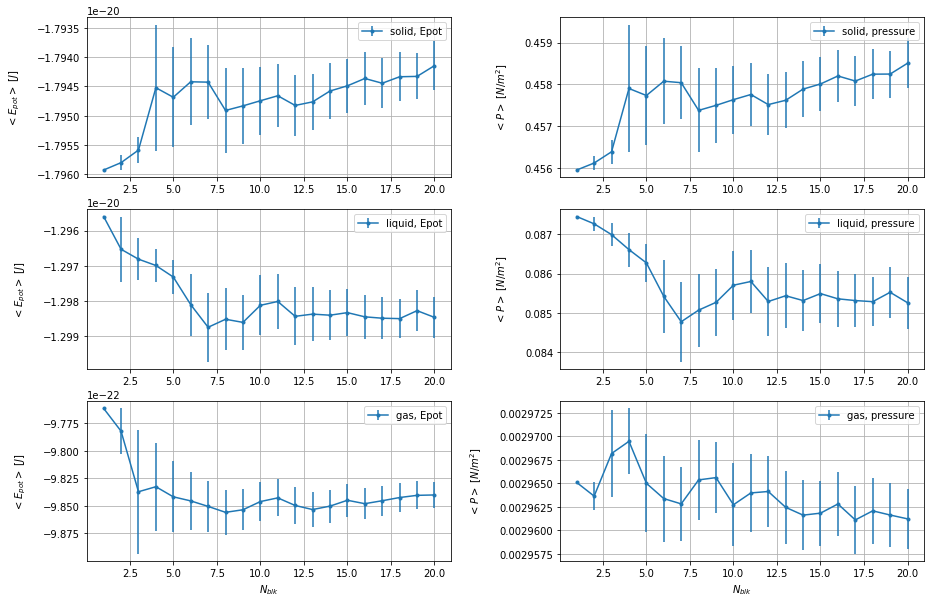

In [16]:
obs_graph(True)

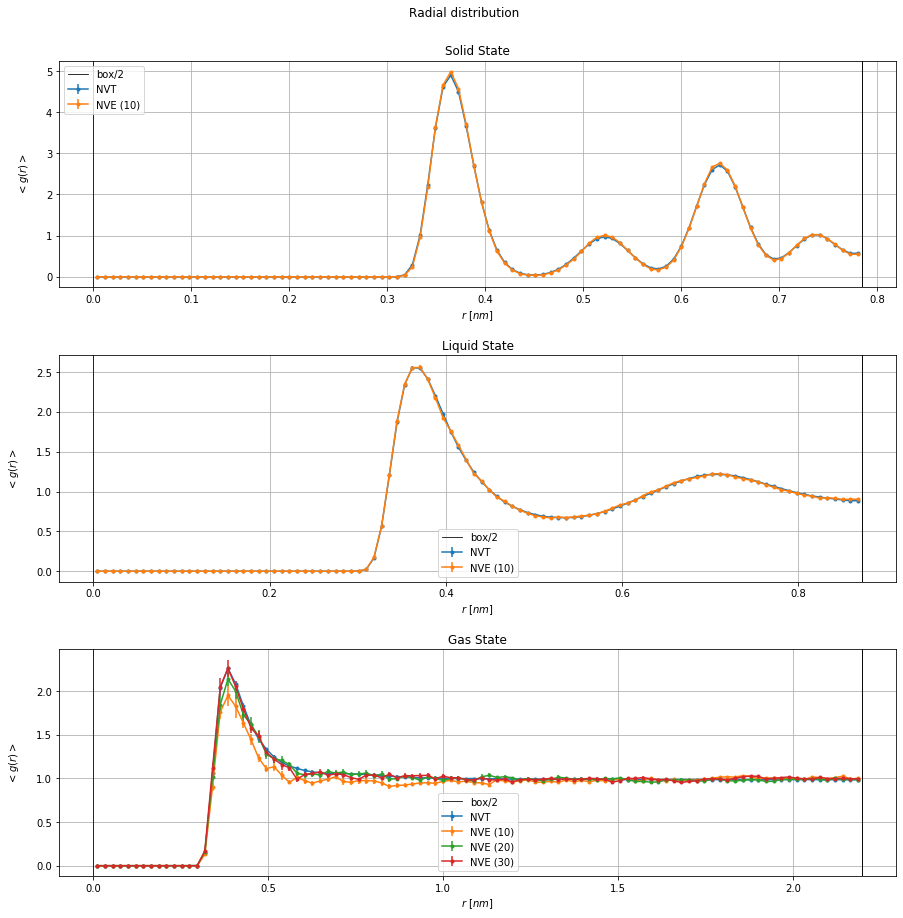

In [17]:
NVE_L_s,NVE_binS=np.genfromtxt('results/output.solid.gave.10.NVE',max_rows=1)             # Number of throws in each block, bin size
NVE_L_l,NVE_binL=np.genfromtxt('results/output.liquid.gave.10.NVE',max_rows=1) 
NVE_L_g,NVE_binG=np.genfromtxt('results/output.gas.gave.10.NVE',max_rows=1) 
NVE_gS=np.genfromtxt('results/output.solid.gave.10.NVE',skip_header=1,names='nbin,res,err')
NVE_gL=np.genfromtxt('results/output.liquid.gave.10.NVE',skip_header=1,names='nbin,res,err')
NVE_gG=np.genfromtxt('results/output.gas.gave.10.NVE',skip_header=1,names='nbin,res,err')
g20=np.genfromtxt('results/output.gas.gave.20.NVE',skip_header=1,names='nbin,res,err')
g30=np.genfromtxt('results/output.gas.gave.30.NVE',skip_header=1,names='nbin,res,err')    

L_NVE=(NVE_L_s,NVE_L_l,NVE_L_g); bin_width_NVE=(NVE_binS,NVE_binL,NVE_binG)
gofr_NVE=(NVE_gS,NVE_gL,NVE_gG,g20,g30);
for i in range(3): gofr_NVE[i]['nbin']=(gofr_NVE[i]['nbin']+1./2.)*bin_width_NVE[i]*sig
for i in (3,4): gofr_NVE[i]['nbin']=(gofr_NVE[i]['nbin']+1./2.)*bin_width_NVE[2]*sig

title_State=('Solid','Liquid','Gas')
pl.figure(figsize=(15,15))
for i in range(3):
    pl.subplot(3,1,i+1)
    pl.errorbar(gofr[i]['nbin']*sig,gofr[i]['res'],yerr=gofr[i]['err'],marker='.',label='NVT')
    pl.errorbar(gofr_NVE[i]['nbin'],gofr_NVE[i]['res'],yerr=gofr_NVE[i]['err'],marker='.',label='NVE (10)')
    if i==2:
        pl.errorbar(gofr_NVE[i+1]['nbin'],gofr_NVE[i+1]['res'],yerr=gofr_NVE[i+1]['err'],marker='.',label='NVE (20)')
        pl.errorbar(gofr_NVE[i+2]['nbin'],gofr_NVE[i+2]['res'],yerr=gofr_NVE[i+2]['err'],marker='.',label='NVE (30)')
    pl.axvline(x=0,color='k',linewidth=0.8,label='box/2')
    pl.axvline(x=100*bin_width[i]*sig,color='k',linewidth=0.8)
    pl.axvline(x=100*bin_width_NVE[i]*sig,color='k',linewidth=0.8)
    pl.legend(loc='best')
    pl.xlabel('$r \ [nm]$')
    pl.ylabel('$<g(r)>$',labelpad=15)
    pl.title(title_State[i]+' State')
    pl.grid(True)
pl.subplots_adjust(hspace=0.3)
pl.suptitle('Radial distribution', y=0.93)
pl.show()